# DS SC23x 
## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 데이터를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 이 [PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 오늘 여러분은 Chicago시의 공중보건부가 진행한 위생 검사의 실패 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [120]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [121]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv'
test_url  = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv'

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape  == (20000, 17)

# Part 1: 데이터 전처리 (Data Preprocessing)

In [122]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Inspection ID    20000 non-null  int64  
 1   DBA Name         20000 non-null  object 
 2   AKA Name         19765 non-null  object 
 3   License #        20000 non-null  float64
 4   Facility Type    19548 non-null  object 
 5   Risk             19998 non-null  object 
 6   Address          20000 non-null  object 
 7   City             19989 non-null  object 
 8   State            19997 non-null  object 
 9   Zip              19996 non-null  float64
 10  Inspection Date  20000 non-null  object 
 11  Inspection Type  20000 non-null  object 
 12  Violations       14664 non-null  object 
 13  Latitude         19940 non-null  float64
 14  Longitude        19940 non-null  float64
 15  Location         19940 non-null  object 
 16  Inspection Fail  20000 non-null  int64  
dtypes: float64(4

In [123]:
test.head() # 헤드 확인

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2293964,DUNKIN' DONUTS/JET BOX,DUNKIN' DONUTS/JET BOX,2601006.0,Restaurant,Risk 2 (Medium),5700 S CICERO AVE,CHICAGO,IL,60638.0,2019-06-20,Canvass,NaN,41.789329,-87.741646,"(-87.74164564419637, 41.789329323265385)",0
1,176607,WHALE FISH AND CHICKEN INC,WHALE FISH AND CHICKEN,1356889.0,Restaurant,Risk 2 (Medium),4955 W MADISON ST,CHICAGO,IL,60644.0,2010-03-11,Short Form Complaint,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.880330,-87.749790,"(-87.74978951712637, 41.880330453312716)",0
2,2290261,NUMERO UNO SUPER MERCADO,NUMERO UNO SUPER MERCADO,2583216.0,Grocery Store,Risk 3 (Low),3600 W DIVERSEY AVE,CHICAGO,IL,60647.0,2019-05-21,Canvass,NaN,41.932020,-87.717258,"(-87.71725848978885, 41.932019940834046)",0
3,1150461,KIKI'S CHOP SUEY,KIKI'S CHOP SUEY,1542186.0,NaN,Risk 1 (High),1122 W 95TH ST,CHICAGO,IL,60643.0,2012-06-13,Canvass,NaN,41.721465,-87.651677,"(-87.65167725164933, 41.72146477432785)",0
4,2081419,LOTUS BANH MI,LOTUS BANH MI,2551375.0,Restaurant,Risk 1 (High),166 W WASHINGTON ST,CHICAGO,IL,60602.0,2017-08-31,License,NaN,41.883317,-87.632917,"(-87.63291657190607, 41.883317146617586)",0


In [124]:
test.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            235
License #             0
Facility Type       452
Risk                  2
Address               0
City                 11
State                 3
Zip                   4
Inspection Date       0
Inspection Type       0
Violations         5336
Latitude             60
Longitude            60
Location             60
Inspection Fail       0
dtype: int64

In [125]:
test.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Inspection Fail
count,2.000000e+04,2.000000e+04,19996.000000,19940.000000,19940.000000,20000.000000
mean,1.513162e+06,1.614612e+06,60628.975545,41.879945,-87.676127,0.194900
std,6.565450e+05,9.058379e+05,21.839537,0.080831,0.058677,0.396134
min,4.822900e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000
25%,1.184356e+06,1.224086e+06,60614.000000,41.831003,-87.707006,0.000000
50%,1.522342e+06,1.990956e+06,60625.000000,41.891490,-87.665857,0.000000
75%,2.088734e+06,2.269935e+06,60643.000000,41.939258,-87.634789,0.000000
max,2.402020e+06,3.808691e+06,60827.000000,42.021064,-87.525094,1.000000


In [126]:
test.corr()

,Inspection ID,License #,Zip,Latitude,Longitude,Inspection Fail
Inspection ID,1.000000,0.248108,0.016862,0.031929,0.004082,-0.033450
License #,0.248108,1.000000,-0.016083,-0.019712,0.036985,0.035052
Zip,0.016862,-0.016083,1.000000,0.176647,-0.396810,0.009817
Latitude,0.031929,-0.019712,0.176647,1.000000,-0.424061,-0.009863
Longitude,0.004082,0.036985,-0.396810,-0.424061,1.000000,0.016165
Inspection Fail,-0.033450,0.035052,0.009817,-0.009863,0.016165,1.000000


In [127]:
test['Inspection Fail'].value_counts()

0    16102
1     3898
Name: Inspection Fail, dtype: int64

In [128]:
train['Risk'].value_counts()

Risk 1 (High)      42839
Risk 2 (Medium)    11757
Risk 3 (Low)        5368
All                   12
Name: Risk, dtype: int64

In [129]:
test['Address'].value_counts()

11601 W TOUHY AVE      250
2300 S THROOP ST        48
500 W MADISON ST        48
5700 S CICERO AVE       47
324 N LEAVITT ST        38
                      ... 
2610 N HALSTED ST        1
3614 W 16TH ST           1
1752 W NORTH AVE         1
6129 S Ashland AVE       1
5060 N CLARK ST          1
Name: Address, Length: 10357, dtype: int64

In [130]:
test['City'].value_counts()

CHICAGO              19928
Chicago                 22
chicago                 12
CCHICAGO                 7
CALUMET CITY             2
SCHAUMBURG               2
MAYWOOD                  2
CHicago                  1
WORTH                    1
OAK PARK                 1
WADSWORTH                1
NILES NILES              1
312CHICAGO               1
OLYMPIA FIELDS           1
EVANSTON                 1
CHICAGO.                 1
BLUE ISLAND              1
CICERO                   1
CHICAGO HEIGHTS          1
OOLYMPIA FIELDS          1
ELK GROVE VILLAGE        1
Name: City, dtype: int64

In [131]:
test['Facility Type'].value_counts()

Restaurant                      13404
Grocery Store                    2620
School                           1214
Children's Services Facility      310
Bakery                            283
                                ...  
VENDING COMMISSARY                  1
GROCERY/CAFE                        1
CLOTHING STORE                      1
Laundromat                          1
DAYCARE 1586                        1
Name: Facility Type, Length: 215, dtype: int64

In [132]:
test['State'].value_counts()

IL    19997
Name: State, dtype: int64

In [133]:
test.T.duplicated()

Inspection ID      False
DBA Name           False
AKA Name           False
License #          False
Facility Type      False
Risk               False
Address            False
City               False
State              False
Zip                False
Inspection Date    False
Inspection Type    False
Violations         False
Latitude           False
Longitude          False
Location           False
Inspection Fail    False
dtype: bool

## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 진행하세요
> 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다

In [134]:
# AKA NAME = DBA NAME 과 겹치니 제거
# Violations = 결측치 25% -> 제거
# Lat, Long, Loca -> 결측치 60, 중요하지 않아보임 -> 제거
# Facility Type -> 결측치를 None 로 대체 (범주에 없을 뿐인듯)
# 기타 짜잘한 결측치 -> 행 삭제
# ZIP 관련 없어보임 -> 제거
# Inspection ID -> INDEX
# License -> INT
# Riskpoint -> Risk 1(low), 2(mid), 3(high)로 변경, all 있는 항목은 Null 값 넣기
# City -> 개판난거 어차피 시카고가 절대다수인데 제거해버리죠?
# State -> 전부 동일한 값 -> 삭제
# Loca = 무지성 Latitude * Longitude 해버리기~,'Latitude', 'Longitude'
# Inspection Date => datetime 자료형으로 변환 (시간부족)
import numpy as np

def eda(df):
  df = df.drop(['AKA Name','Violations', 'Location','Zip','City','State'], axis=1)
  df['Facility Type'] = df['Facility Type'].fillna('None')
  df = df.set_index('Inspection ID', drop=True)

  temp_list = []
  for i in df['Risk']:
    if i == 'Risk 1 (High)':
      temp = int(3)
      temp_list.append(temp)
    elif i == 'Risk 2 (Medium)':
      temp = int(2)
      temp_list.append(temp)
    elif i == 'Risk 3 (Low)':
      temp = int(1)
      temp_list.append(temp)
    else:
      temp = np.nan
      temp_list.append(temp)
  df['Rp'] = temp_list

  df = df.dropna(axis=0)

  temp_list = []
  for i in df['License #']:
    temp = int(i)
    temp_list.append(temp)
  df['License #'] = temp_list

  df['Loca'] = df['Latitude'] * df['Longitude']
  df = df.drop(['Latitude','Longitude','Risk'], axis=1)

  print(df.shape)
  return df

train_eda = eda(train)
test_eda  = eda(test)

(59783, 9)
(19937, 9)


In [135]:
train_eda.head()

,DBA Name,License #,Facility Type,Address,Inspection Date,Inspection Type,Inspection Fail,Rp,Loca
Inspection ID,,,,,,,,,
2050629,MY SWEET STATION INC,2327223,Restaurant,2511 N LINCOLN AVE,2017-05-18,Canvass,0,3.0,-3675.016177
2078428,OUTTAKES,2125004,Restaurant,10 S DEARBORN ST FL,2017-08-14,Canvass,0,2.0,-3670.083609
1591748,JAFFA BAGELS,2278918,Restaurant,225 N MICHIGAN AVE,2015-12-15,Complaint,0,3.0,-3670.267921
1230035,FRANKS 'N' DAWGS,2094329,Restaurant,1863 N CLYBOURN AVE,2012-07-10,Canvass,0,3.0,-3674.058140
1228186,SOUTH COAST,1817424,Restaurant,1700 S MICHIGAN AVE,2013-09-20,Canvass,0,3.0,-3667.857115


In [136]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59783 entries, 2050629 to 2293426
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DBA Name         59783 non-null  object 
 1   License #        59783 non-null  int64  
 2   Facility Type    59783 non-null  object 
 3   Address          59783 non-null  object 
 4   Inspection Date  59783 non-null  object 
 5   Inspection Type  59783 non-null  object 
 6   Inspection Fail  59783 non-null  int64  
 7   Rp               59783 non-null  float64
 8   Loca             59783 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 4.6+ MB


In [137]:
train_eda.isnull().sum()

DBA Name           0
License #          0
Facility Type      0
Address            0
Inspection Date    0
Inspection Type    0
Inspection Fail    0
Rp                 0
Loca               0
dtype: int64

# Part 2: 모델링 (Modeling)

## 2.1 검증 방식 (Cross-validation / Hold-out validation)을 정한 후 데이터셋을 목적에 맞게 분할하세요

In [138]:
from sklearn.model_selection import train_test_split
target = 'Inspection Fail'
train, val = train_test_split(train_eda, train_size=0.80, test_size=0.20, 
                              stratify=train_eda[target], random_state=2)
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test_eda.drop(columns=target)

In [139]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(47826, 8) (47826,)
(11957, 8) (11957,)
(19937, 8)


## 2.2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)까지 진행하세요
> 모델은 scikit-learn, xgboost 등 어떤 라이브러리를 사용하셔도 괜찮지만 특정 라이브러리는 설치 및 설정에 시간이 소요되는 점을 감안하시기 바랍니다

In [140]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [141]:
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, max_depth=None, min_samples_leaf=3, random_state=22, n_estimators=500, oob_score=True)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))

훈련 정확도:  0.88679797599632


In [142]:
from sklearn.metrics import classification_report
print('검증 정확도', pipe.score(X_val, y_val))

print(classification_report(y_val, pipe.predict(X_val)))

검증 정확도 0.8070586267458393
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      9624
           1       0.54      0.07      0.13      2333

    accuracy                           0.81     11957
   macro avg       0.68      0.53      0.51     11957
weighted avg       0.76      0.81      0.74     11957



## 2.3 테스트셋의 ROC / AUC 검증 점수를 예측합니다
> 제작한 모델을 활용해서 테스트셋의 **확률**을 예측하세요 (`ROC/AUC 검증 점수`를 **0.65 혹은 그 이상** 달성한다면 매우 훌륭한 모델입니다)

Text(0.5, 1.0, 'Confusion matrix, n = 11957')

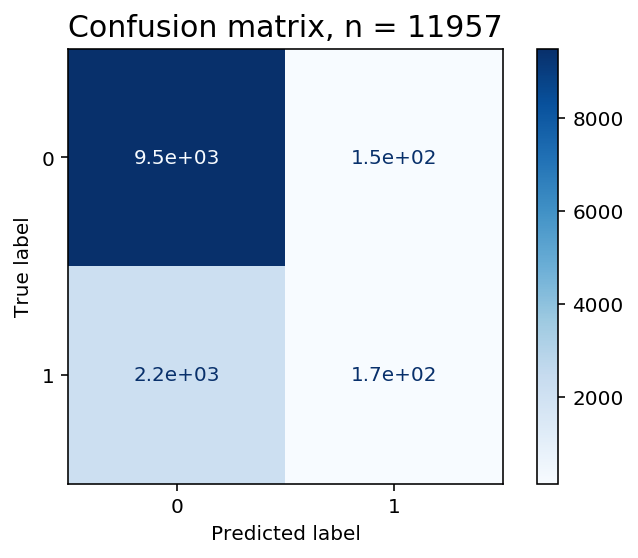

In [143]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

In [144]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

AUC score:  0.6524819051456942


Text(0, 0.5, 'TPR')

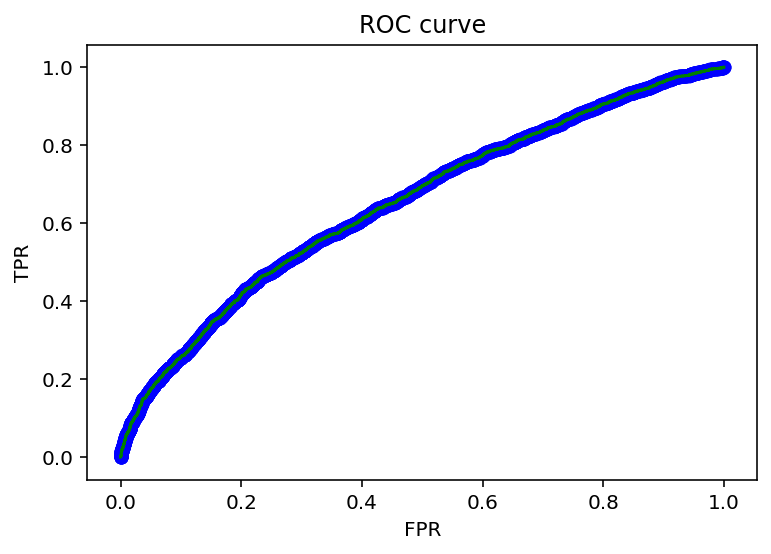

In [145]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

## 2.4 하이퍼 파라미터 튜닝을 통해서 모델을 개선하세요
> `RandomSearchCV`, `GridSearchCV` 등을 활용해서 모델의 성능을 개선합니다. 범위 설정에 따라 시간이 매우 소요될 수 있습니다.

In [146]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
"""
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, max_depth=None, min_samples_leaf=3, random_state=22, n_estimators=500, oob_score=True)
)

pipe.fit(X_train, y_train)

print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))
y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
"""

dists = {
    #'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.], # int로 넣으면 error(bug)
    #'targetencoder__min_samples_leaf': randint(1, 10),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


In [147]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.5893893504957723, 'randomforestclassifier__n_estimators': 411, 'simpleimputer__strategy': 'mean'}
MAE:  0.22993769079580145


In [148]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,2,4,0,1,3
mean_fit_time,32.7095,7.3248,19.0656,17.0112,19.5812
std_fit_time,0.0947784,0.211641,0.161328,0.253003,0.0473821
mean_score_time,1.45201,0.800019,2.15593,1.0041,2.25629
std_score_time,0.00355601,0.148413,0.0995713,0.0484076,0.00719726
param_randomforestclassifier__max_depth,10,5,20,None,20
param_randomforestclassifier__max_features,0.589389,0.0637254,0.0909664,0.482594,0.184278
param_randomforestclassifier__n_estimators,411,364,411,168,422
param_simpleimputer__strategy,mean,median,mean,median,mean
params,"{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran..."
split0_test_score,-0.190106,-0.195124,-0.191193,-0.193284,-0.191151


In [149]:
pipe = clf.best_estimator_

In [150]:
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score:   ', roc_auc_score(y_val, y_pred_proba))

훈련 정확도:  0.8216033120060219
검증 정확도:  0.8095676172953082
AUC score:    0.6704313209689023


## Part 3: 시각화 (Visualization)

> 모델의 해석을 위한 시각화를 해주세요. 아래의 제시 된 종류 중 2가지를 선택하세요 (시각화에 가장 중요한 것은 **여러분의 분석**입니다.):
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [151]:
X_train.columns

Index(['DBA Name', 'License #', 'Facility Type', 'Address', 'Inspection Date',
       'Inspection Type', 'Rp', 'Loca'],
      dtype='object')

In [152]:
# dpi(dots per inch) 수치를 조정해 이미지 화질을 조정 할 수 있습니다
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

In [153]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Rp'

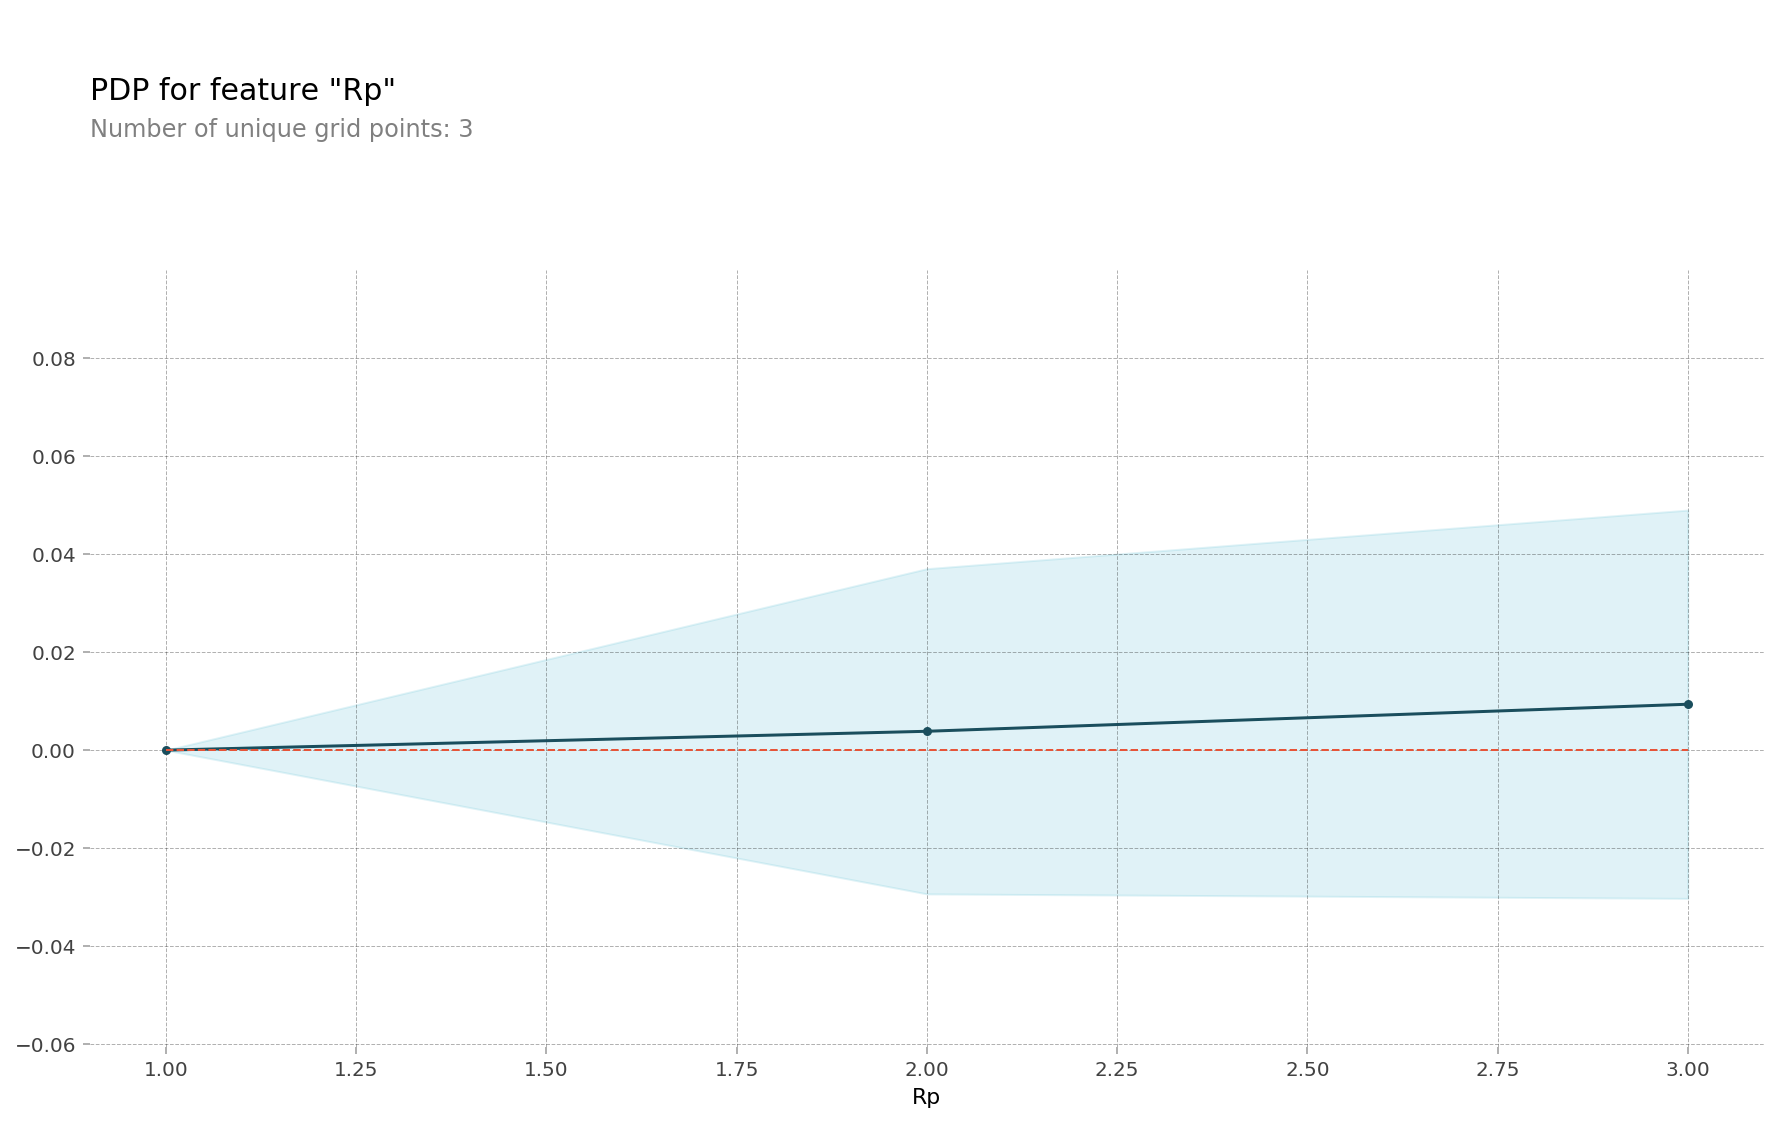

In [154]:
isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

Risk Point 가 증가할수록 위생 검사를 실패할 확률이 올라가긴 하는데 수치가 작아 큰 의미는 없어보이긴 한다.

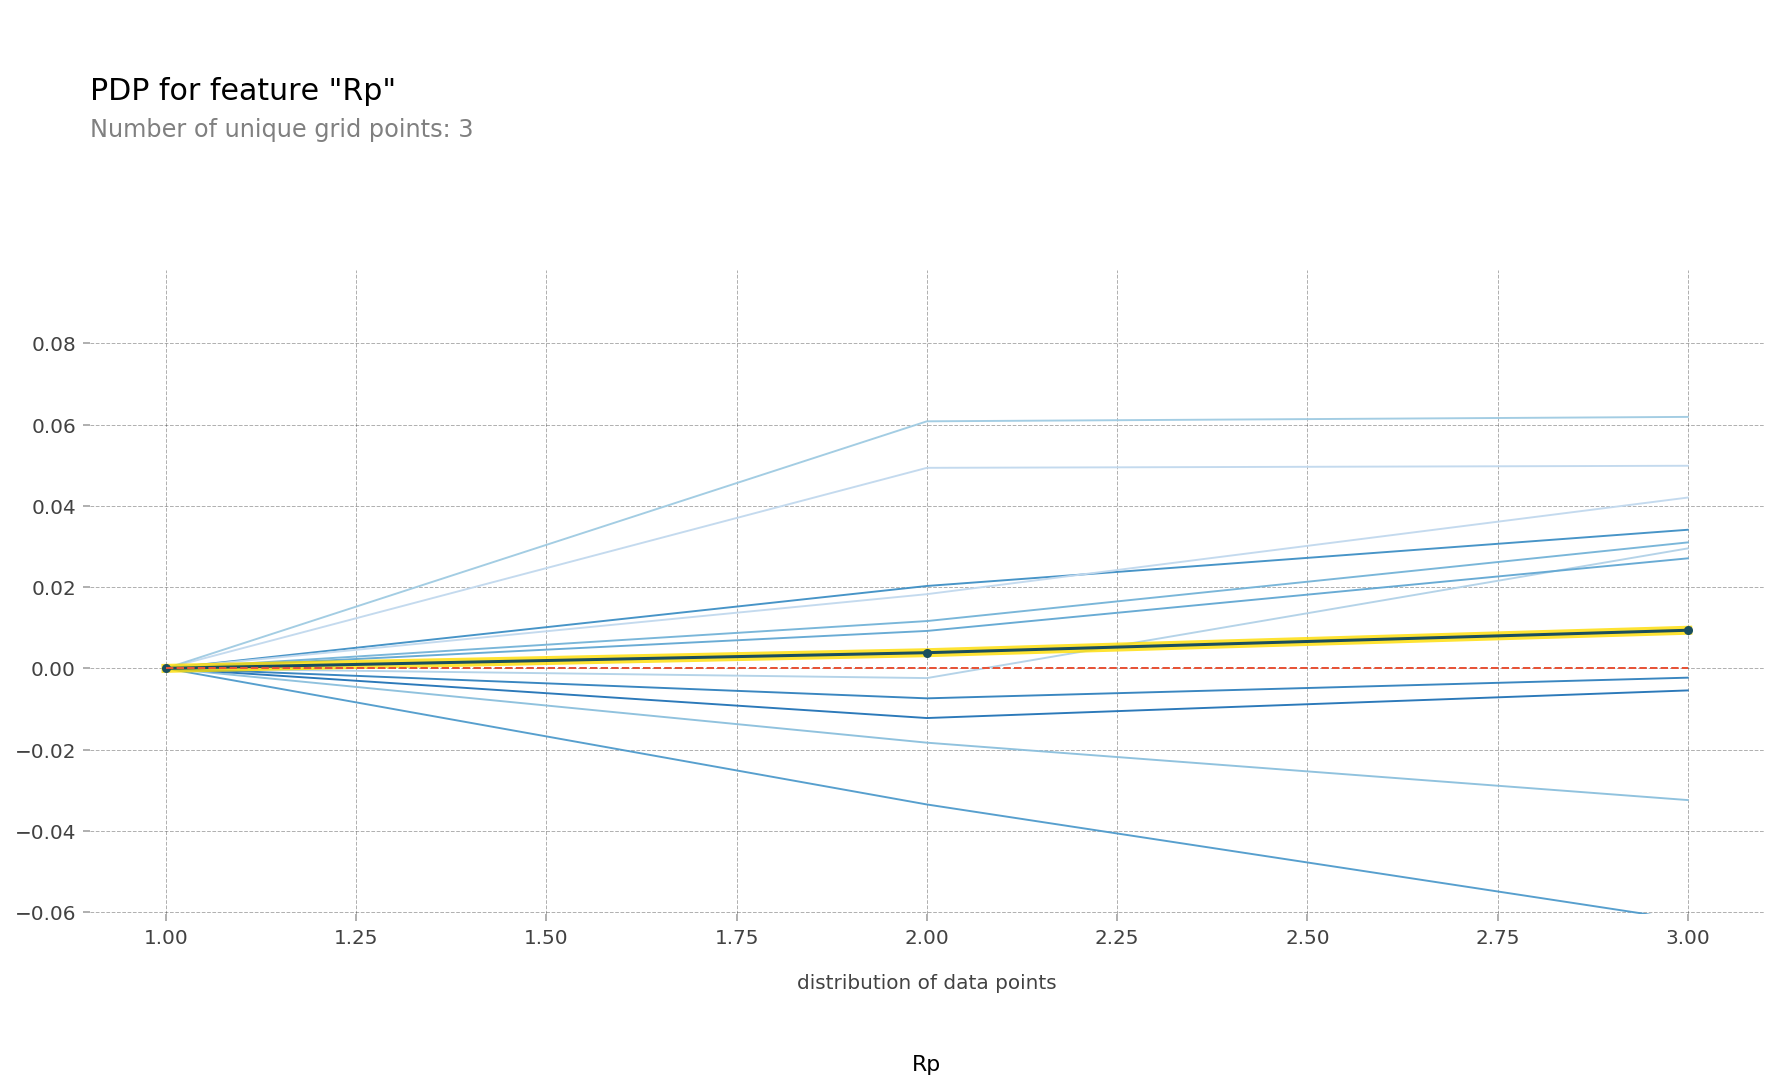

In [155]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True # ICE plots
         , frac_to_plot=0.001 # or 10 (# 10000 val set * 0.001)
         , plot_pts_dist=True) 

plt.xlim(20000,150000);

값도 작고 분산은 너무 크당..

In [156]:
isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    # grid point를 크게 주면 겹치는 점이 생겨 Number of unique grid points는 grid point 보다 작을 수 있습니다.
    num_grid_points=100, # grid 포인트를 더 줄 수 있습니다. default = 10
)


In [157]:
print('예측수: ',len(X_val) * 100)

예측수:  1195700


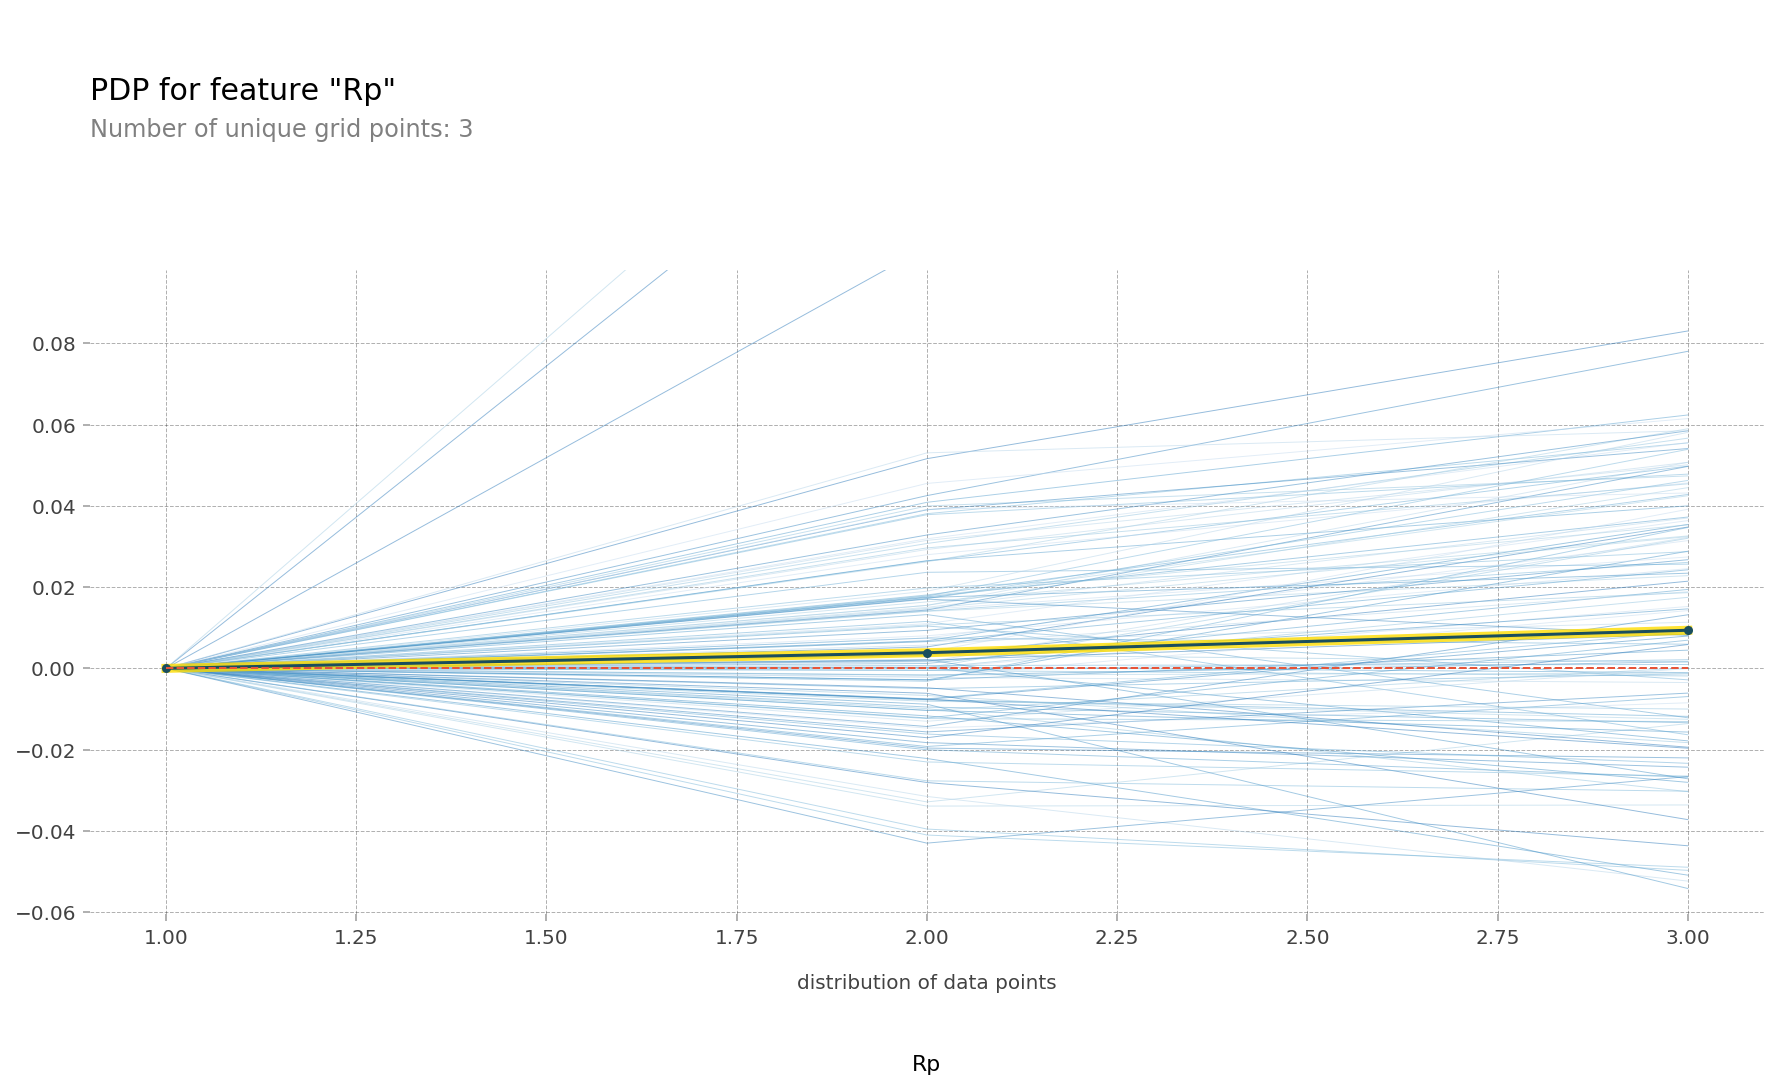

In [158]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True
         , frac_to_plot=0.01 # ICE curves는 100개
         , plot_pts_dist=True )

plt.xlim(20000,150000);

이게뭐지.. ㅇㅅㅇ?

In [160]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [162]:
features = ['Rp', 'Loca']

interaction = pdp_interact(
    model=pipe, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)

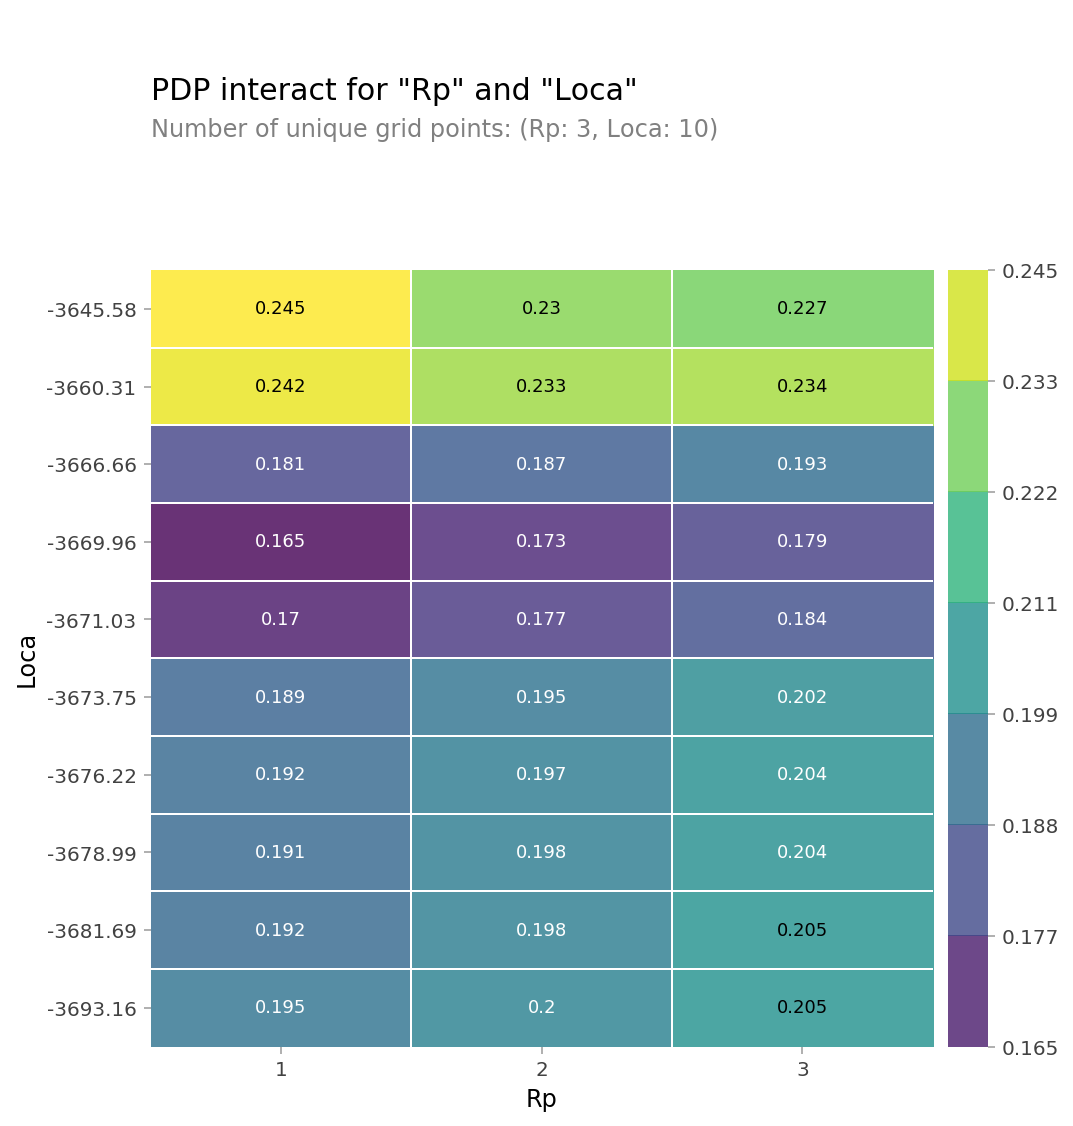

In [163]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

Loca 의 값이 크다는것은 고만큼 북쪽 또는 동쪽에 위치한것이고, \
Rp 는 클수록 위험이 크다는것을 의미. \
좌표를 곱해놔서 지금 Feature로 판단하기로는 무리가 있지만 
아마 남쪽으로 갈수록 위험도가 증가하는 것을 의미하는듯 하다.